# Zscore para detección de anomalías

Este ejemplo muestra el uso de zscore para detección de anomalías. Su uso nos ayuda a comprender si el valor de un dato es mayor o menor que la media y qué tan lejos está de la media. Más específicamente, Z-score indica a cuántas desviaciones estándar se encuentra un punto de datos de la media.

Para generar los datos utilizaremos funciones de la librería PyOD.

Paso 1. Instalamos la librería PyOD

In [ ]:
!pip install pyod

Paso 2. Importamos las librerías que necesitamos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyod.utils.data import generate_data
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

Paso 3. Generamos datos sintéticos. En este caso, vamos a trabajar con datos de entrenamiento y datos de test. Para tener un conjunto considerable de datos de forma rápida, vamos a generarlos utilizando el método *generate_data* que nos permite definir el número de instancias, las dimensiones y el porcentaje de outliers que queremos.

Rercordamos que aunque el método no usará el atributo que determina si es una anomalía o no para realizar su procesamiento, las tenemos disponibles con la finalidad de comparar los resultados.

In [ ]:
# Porcentaje de outliers que vamos a considerar
contamination = 0.1

#Número de ejemplos de entrenamiento y test que vamos a utilizar
n_train = 200  
n_test = 100  

# Generamos los datos, considerando 2 dimensiones y las características anteriores
# Utilizamos como generador de datos aleatorios (random_state) la semilla 12, 
# para que en todas las ejecuciones obtengamos los mismos datos.
X_train, X_test, y_train, y_test = generate_data(n_train=n_train, n_test=n_test, n_features=2, behaviour='new', contamination=contamination,random_state=12)


Paso 4. Visualizamos los datos que hemos generado para train (entrenamieto) y test (prueba), lo representamos en diferente color los puntos que son anomalías de los que no.

In [ ]:
#Creamos una nueva variable DataFrame para que incorpore en los datos de entrenamiento
# el atributo la etiqueta de anomalía o no.
# Lo usamos solamente para la representación, los datos que usará el modelo sigue
#sin tener esa información
XY_train = pd.DataFrame({"Variable 1": X_train[:,0], "Variable 2": X_train[:,1], "Anomalía": y_train})

#Lo representamos gráficamente poniendo el color en función de si es anómalo o no
plt.scatter(XY_train['Variable 1'], XY_train['Variable 2'], c=XY_train['Anomalía'])
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title("Distribución de los datos training")
plt.show()

#Creamos una nueva variable DataFrame para que incorpore en los datos de test 
# el atributo la etiqueta de anomalía o no solamente para la representación. 
# El conjunto de test que usaremos en el modelo sigue sin tener esa información
XY_test = pd.DataFrame({"Variable 1": X_test[:,0], "Variable 2": X_test[:,1], "Anomalía": y_test})

#Lo representamos gráficamente poniendo el color en función de si es anómalo o no
plt.scatter(XY_test['Variable 1'], XY_test['Variable 2'], c=XY_test['Anomalía'])
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title("Distribución de los datos test")
plt.show()

Paso 5. Aplicamos el métodos de Zscore
Para descubrir y filtrar los valores atípicos en el conjunto de datos, se va a crear una función que nos indicará los valores atípicos de acuerdo con el valor de Zscore. En la función, primero debemos averiguar el valor de zscore de cada punto. En segundo lugar, seleccionaremos los puntos que se encuentran con valores menores de -3 o mayores de +3 y esos valores los marcaremos como anomalías en la predicción de esos puntos.

Al ser univariante, lo haremos para **cada** dimensión.

In [ ]:
#Para cada dimensión
#Calculamos la media y la desviación típica (dimensión 1)
media_d1 = np.mean(X_train[:,0])
std_d1 = np.std(X_train[:,0])
#Lo mostramos por pantalla
print('La media (dimensión 1) es:', media_d1)
print('La desviacón típica (dimensión 1) es:', std_d1)

#Calculamos la media y la desviación típica (dimensión 2)
media_d2 = np.mean(X_train[:,1])
std_d2 = np.std(X_train[:,1])
#Lo mostramos por pantalla
print('La media (dimensión 2) es:', media_d1)
print('La desviacón típica (dimensión 2) es:', std_d2)


#Calculamos el zscore si es mayor o menor de 3 lo consideramos anomalía.
#Vamos a establecer la variable y_train_pred y y_test_pred, para indicar
#los valores que predice este método en los datos de train y test: un 0
#indica una anomalía y un valor de 1 indica un valor normal.
#Cuando veamos la librería PyOD veremos que lo hace de forma similar.

#Umbral para determinarl la anomalias
threshold = 3
#Variables donde introduciremos si es anomalía o no
y_train_pred = []
y_test_pred = []


#Para train
# si en cualquiera de las dimensiones de esa instancia se supera el umbral
# vamos a considerar esa instancia es anómala valor 1, sino 0 (normal)
for x in X_train: 
    z_d1 = (x[0]-media_d1)/std_d1
    z_d2 = (x[1]-media_d2)/std_d2

    if ( (z_d1 > threshold) or (z_d1<(-threshold)) or (z_d2 > threshold) or (z_d2<(-threshold))): 
         y_train_pred.append(1)
    else:
         y_train_pred.append(0)

# Para test
# si en cualquiera de las dimensiones de esa instancia se supera el umbral
# vamos a considerar esa instancia es anómala valor 1, sino 0 (normal)
for x in X_test: 
    z_d1 = (x[0]-media_d1)/std_d1
    z_d2 = (x[1]-media_d2)/std_d2

    if ( (z_d1 > threshold) or (z_d1<(-threshold)) or (z_d2 > threshold) or (z_d2<(-threshold))): 
         y_test_pred.append(1)
    else:
         y_test_pred.append(0)

#Mostramos las etiquetas asignadas a cada instancia tanto reales como predichas 
print('Etiquetas reales datos train: ', y_train)
print('Etiquetas reales datos test: ', y_test)

print('Etiquetas predichas datos train: ', y_train_pred)
print('Etiquetas predichas datos test: ', y_test_pred)

Paso 6. Visualizamos los resultados para ver si el método ha reconocido adcuadamente todas las anomalías.

a) Visualizamos los datos reales y predichos para training

In [ ]:
#Creamos una nueva variable de training para que incorpore como atributo la etiqueta de anomalía
#predicha, con las anomalías reales ya lo hicimos en el paso 4 de visualización
XY_train_pred = pd.DataFrame({"Variable 1": X_train[:,0], "Variable 2": X_train[:,1], "Anomalía": y_train_pred})

# Creamos la figura para los datos predichos
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión anomalía que hemos añadido en XY_train_pred
plt.scatter(XY_train_pred['Variable 1'], XY_train_pred['Variable 2'], c = XY_train_pred['Anomalía'], marker='o')
plt.title("Conjunto de train - Predicho")
# Mostramos el gráfico
plt.show()


# Creamos la figura para los datos reales
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión Anomalia que hemos añadido en XY_train
plt.scatter(XY_train['Variable 1'], XY_train['Variable 2'], c = XY_train['Anomalía'], marker='o')
plt.title("Conjunto de train - Real")
# Mostramos el gráfico
plt.show()

b) Visualizamos ahora los datos reales y predichos para test

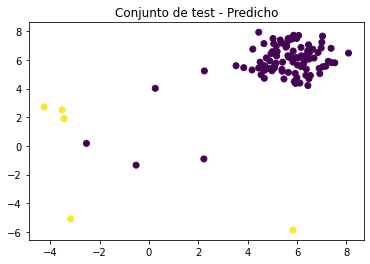

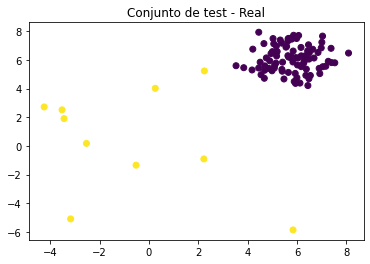

In [ ]:
#Creamos una nueva variable de test para que incorpore tanto las anomalías reales 
#como las predichas, con las anomalías reales ya lo hicimos en el paso 4 de visualización
XY_test_pred = pd.DataFrame({"Variable 1": X_test[:,0], "Variable 2": X_test[:,1], "Anomalía": y_test_pred})

# Creamos la figura para los datos predichos
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión anomalía que hemos añadido en XY_test_pred
plt.scatter(XY_test_pred['Variable 1'], XY_test_pred['Variable 2'], c = XY_test_pred['Anomalía'], marker='o')
plt.title("Conjunto de test - Predicho")
# Mostramos el gráfico
plt.show()


# Creamos la figura paralos datos reales
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión Anomalia que hemos añadido en XY_test
plt.scatter(XY_test['Variable 1'], XY_test['Variable 2'], c = XY_test['Anomalía'], marker='o')
plt.title("Conjunto de test - Real")
# Mostramos el gráfico
plt.show()

**Comentario visualización:** se puede apreciar que en los datos de test falla en 5 ejemplos, que son anómalos y los identifica como normales. En los datos de train, le ocurre lo mismo con 7 ejemplos.

Paso 7. Calculamos las medidas que hemos visto para evaluar el rendimiento del método, partiendo de la matriz de confusión y también usando directamente la librería skearn.metrics

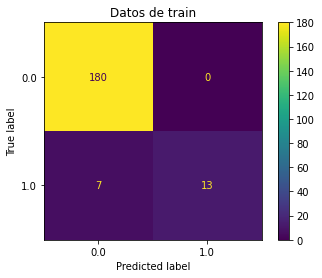

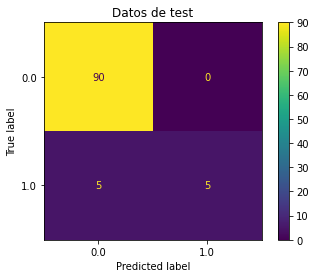

In [ ]:
#Mostramos la matriz de confusión para datos de train
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Datos de train")
plt.show()

#Mostramos la matriz de confusión para datos de test
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Datos de test")
plt.show()


A continuación vamos a mostrar la curva ROC-AUC, sensibilidad, especificidad y precisión.

In [ ]:
#Calculamos las medidas para train
print('Medidas para train')
print('------------------')
#Calculamos la matriz de confusión
cm = confusion_matrix(y_train,y_train_pred)
print('Matriz de confusión : \n', cm)
total=sum(sum(cm))

#Calculamos sensibilidad y especificidad desde la matriz de confusión
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensibilidad : ', sensitivity )
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Especificidad: ', specificity)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Precisión: ', precision)

#Calculamos las otras métricas desde la librería
print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred, average=None))


#Calculamos las medidas para test
print('Medidas para test')
print('------------------')
#Calculamos la matriz de confusión
cm = confusion_matrix(y_test,y_test_pred)
print('Matriz de confusión : \n', cm)
total=sum(sum(cm))

#Calculamos sensibilidad y especificidad desde la matriz de confusión
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensibilidad : ', sensitivity )
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Especificidad: ', specificity)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Precisión: ', precision)

#Calculamos las otras métricas desde la librería
print('ROC-AUC: ', roc_auc_score(y_test, y_test_pred, average=None))


Medidas para train
------------------
Matriz de confusión : 
 [[180   0]
 [  7  13]]
Sensibilidad :  0.65
Especificidad:  1.0
Precisión:  1.0
ROC-AUC:  0.825
Medidas para test
------------------
Matriz de confusión : 
 [[90  0]
 [ 5  5]]
Sensibilidad :  0.5
Especificidad:  1.0
Precisión:  1.0
ROC-AUC:  0.75


**Comentarios métricas:** Se puede ver que para los datos de test en este caso los resultados son algo peores que en los datos de entrenamiento (train). Aunque se consigue una especificidad de un 100% tanto en train como en test, es decir, se consigue clasificar correctamente todas las instancias normales, nos encontramos que la sensibilidad (es decir el porcentaje de aciertos con respecto la clase anómala) es de un 65% en train y un 50% en test, lo que muestra que este método no tiene tan buen rendimiento pues solamente clasifica correctamente el 50% de los ejemplos anómalos. También, a través de la precisión con un valor de 100%, nos muestra que los fallos cometidos han sido por detectar como normales, observaciones que eran anormales, uno de los fallos que más debemos evitar. El área bajo la curva nos indica que con un 82.5% de probabilidad en train y 75% de probabilidad en test se acierta si la clase es anómala o no. Quizás cambiando el nivel de confianza como hemos visto en teoría y estableciendo el umbral en [-2,2], en lugar de 3, obtendríamos mejores resultados para este problema. Te animo a que lo pruebes. Así como ir cambiando el número de anomalías que se considera en los datos.
